In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import svm, neighbors, linear_model, neural_network
from sklearn.svm import NuSVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from tqdm import tqdm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from vecstack import stacking 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
import sympy
from sklearn.covariance import EmpiricalCovariance
from sklearn.mixture import GaussianMixture
from sklearn.covariance import GraphicalLasso


In [2]:
def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps


In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')


cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))


In [4]:

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=24, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        gm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps, verbose=0, verbose_interval=10000)
        gm.fit(np.concatenate([train3[train_index,:],test3],axis = 0))
        oof[idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
        preds[idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits
        
    #if i%64==0: print(i)



100%|██████████| 512/512 [42:18<00:00,  5.18s/it]


In [5]:
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))


QDA scores CV = 0.96906


In [6]:
print(len(train.loc[ abs(train['target']-oof)>0.9,'target'])/len(train))

0.038074493408203125


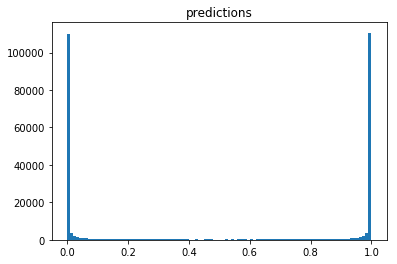

In [7]:
import matplotlib.pyplot as plt
plt.hist(oof,bins=100)
plt.title('predictions')
plt.show()

In [8]:
# INITIALIZE VARIABLES
print('flip started')
test['target'] = preds

# flip y
train_new = train.copy()
train.loc[oof > 0.9, 'target'] = 1
train.loc[oof < 0.1, 'target'] = 0


print('flip completed')


flip started
flip completed


In [9]:
oof_svnu = np.zeros(len(train)) 
pred_te_svnu = np.zeros(len(test))
oof_svc = np.zeros(len(train)) 
pred_te_svc = np.zeros(len(test))
oof_knn = np.zeros(len(train)) 
pred_te_knn = np.zeros(len(test))
oof_lr = np.zeros(len(train)) 
pred_te_lr = np.zeros(len(test))
oof_mlp = np.zeros(len(train)) 
pred_te_mlp = np.zeros(len(test))
oof_lgb = np.zeros(len(train)) 
pred_te_lgb = np.zeros(len(test))
oof_xgb = np.zeros(len(train)) 
pred_te_xgb = np.zeros(len(test))
oof_qda = np.zeros(len(train)) 
pred_te_qda = np.zeros(len(test))

oof_svnu2 = np.zeros(len(train)) 
pred_te_svnu2 = np.zeros(len(test))
oof_svc2 = np.zeros(len(train)) 
pred_te_svc2 = np.zeros(len(test))
oof_knn2 = np.zeros(len(train)) 
pred_te_knn2 = np.zeros(len(test))
oof_lr2 = np.zeros(len(train)) 
pred_te_lr2 = np.zeros(len(test))
oof_mlp2 = np.zeros(len(train)) 
pred_te_mlp2 = np.zeros(len(test))
oof_lgb2 = np.zeros(len(train)) 
pred_te_lgb2 = np.zeros(len(test))
oof_xgb2 = np.zeros(len(train)) 
pred_te_xgb2 = np.zeros(len(test))
oof_qda2 = np.zeros(len(train)) 
pred_te_qda2 = np.zeros(len(test))

oof_lr3 = np.zeros(len(train)) 
pred_te_lr3 = np.zeros(len(test))
oof_gm = np.zeros(len(train)) 
pred_te_gm = np.zeros(len(test))


In [10]:
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

for i in range(512):
    train2_o = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    train2 = train2_o.copy()
    idx1 = train2_o.index; idx2 = test2.index
    #train2.reset_index(drop=True,inplace=True)
    
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2 = pd.concat([train2,test2p],axis=0)
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2_o[cols]), pd.DataFrame(test2[cols])])
    pca = PCA(svd_solver='full',n_components='mle')
    ss = StandardScaler()
    pca.fit(data[cols])
    data2 = pca.transform(data[cols])
    train3_o = pca.transform(train2_o[cols])
    train3 = pca.transform(train2[cols])
    test3 = pca.transform(test2[cols])
    ss.fit(data2)
    train3 = ss.transform(train3)
    train3_o = ss.transform(train3_o)
    test3 = ss.transform(test3)
    #data2 = StandardScaler().fit_transform(PCA(svd_solver='full',n_components='mle').fit_transform(data[cols]))
    #train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]
    pca = VarianceThreshold(threshold=1.5)
    ss = StandardScaler()
    pca.fit(data[cols])
    data3 = pca.transform(data[cols])
    train4_o = pca.transform(train2_o[cols])
    train4 = pca.transform(train2[cols])
    test4 = pca.transform(test2[cols])
    ss.fit(data3)
    train4 = ss.transform(train4)
    train4_o = ss.transform(train4_o)
    test4 = ss.transform(test4)
    
    data4 = ss.transform(data3)
    poly = PolynomialFeatures(degree=2)
    poly.fit(data4)
    train5_o = poly.transform(train4_o)
    train5 = poly.transform(train4)
    test5 = poly.transform(test4)
    
    del data, data2, data3, data4
    
    # STRATIFIED K FOLD (Using splits=25 scores 0.002 better but is slower)
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train2, train2['target']):
        
        test_index = test_index[ test_index<len(train2_o) ] # ignore psuedo in oof

        clf = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_svnu[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_svnu[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = neighbors.KNeighborsClassifier(n_neighbors=17, p=2.9, n_jobs=-1)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_knn[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_knn[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1, n_jobs=-1)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_lr[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_lr[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(250, ))
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_mlp[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_mlp[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = svm.SVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=42)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_svc[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_svc[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = LGBMClassifier(random_state=42)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_lgb[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_lgb[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = XGBClassifier(random_state=42)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_xgb[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_xgb[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        clf = QuadraticDiscriminantAnalysis(0.1)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_qda[idx1[test_index]] = clf.predict_proba(train3_o[test_index,:])[:,1]
        pred_te_qda[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        ###############################################################################
        clf = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_svnu2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_svnu2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = neighbors.KNeighborsClassifier(n_neighbors=17, p=2.9, n_jobs=-1)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_knn2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_knn2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1, n_jobs=-1)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_lr2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_lr2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(250, ))
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_mlp2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_mlp2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = svm.SVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=42)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_svc2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_svc2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = LGBMClassifier(random_state=42)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_lgb2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_lgb2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = XGBClassifier(random_state=42)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_xgb2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_xgb2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        clf = QuadraticDiscriminantAnalysis(0.1)
        clf.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oof_qda2[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,1]
        pred_te_qda2[idx2] += clf.predict_proba(test4)[:,1] / skf.n_splits
        
        #####################################################################################
        
        clf = linear_model.LogisticRegression(solver='saga',penalty='l2',C=0.01,tol=0.001, n_jobs=-1)
        clf.fit(train5[train_index,:],train2.loc[train_index]['target'])
        oof_lr3[idx1[test_index]] = clf.predict_proba(train5_o[test_index,:])[:,1]
        pred_te_lr3[idx2] += clf.predict_proba(test5)[:,1] / skf.n_splits
        
        ms, ps = get_mean_cov(train4[train_index,:],train2.loc[train_index]['target'].values)
        clf = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
        clf.fit(np.concatenate([train4[train_index,:],test4],axis = 0))
        oof_gm[idx1[test_index]] = clf.predict_proba(train4_o[test_index,:])[:,0]
        pred_te_gm[idx2] += clf.predict_proba(test4)[:,0] / skf.n_splits
    
    if i%64==0: print(i)
        
        
        
        


0
64
128
192
256
320
384
448


In [11]:
print('lr', roc_auc_score(train_new['target'], oof_lr))
print('knn', roc_auc_score(train_new['target'], oof_knn))
print('svc', roc_auc_score(train_new['target'], oof_svc))
print('svcnu', roc_auc_score(train_new['target'], oof_svnu))
print('mlp', roc_auc_score(train_new['target'], oof_mlp))
print('lgb', roc_auc_score(train_new['target'], oof_lgb))
print('xgb', roc_auc_score(train_new['target'], oof_xgb))
print('qda', roc_auc_score(train_new['target'], oof_qda))

print('lr', roc_auc_score(train_new['target'], oof_lr2))
print('knn', roc_auc_score(train_new['target'], oof_knn2))
print('svc', roc_auc_score(train_new['target'], oof_svc2))
print('svcnu', roc_auc_score(train_new['target'], oof_svnu2))
print('mlp', roc_auc_score(train_new['target'], oof_mlp2))
print('lgb', roc_auc_score(train_new['target'], oof_lgb2))
print('xgb', roc_auc_score(train_new['target'], oof_xgb2))
print('qda', roc_auc_score(train_new['target'], oof_qda2))


print('lr', roc_auc_score(train_new['target'], oof_lr3))
print('gm', roc_auc_score(train_new['target'], oof_gm))


lr 0.8120002202091721
knn 0.9356827444636515
svc 0.9633992030339213
svcnu 0.9683767388877126
mlp 0.9427105623515943
lgb 0.8767298150863782
xgb 0.8515156946160211
qda 0.9684132341380736
lr 0.8115682569372643
knn 0.9359205211186393
svc 0.9548242390588377
svcnu 0.9640175351375389
mlp 0.9392337878509899
lgb 0.8702564492334319
xgb 0.8443727983255934
qda 0.9685846570438701
lr 0.9623859780878754
gm 0.9673468853483506


In [12]:
tr = train[cols].copy()
te = test[cols].copy()

tr['oof_svnu'] = oof_svnu
te['oof_svnu'] = pred_te_svnu
tr['oof_svc'] = oof_svc
te['oof_svc'] = pred_te_svc
tr['oof_knn'] = oof_knn
te['oof_knn'] = pred_te_knn
tr['oof_mlp'] = oof_mlp
te['oof_mlp'] = pred_te_mlp
tr['oof_lr'] = oof_lr
te['oof_lr'] = pred_te_lr
tr['oof_lgb'] = oof_lgb
te['oof_lgb'] = pred_te_lgb
tr['oof_xgb'] = oof_xgb
te['oof_xgb'] = pred_te_xgb
tr['oof_qda'] = oof_qda
te['oof_qda'] = pred_te_qda

tr['oof_svnu2'] = oof_svnu2
te['oof_svnu2'] = pred_te_svnu2
tr['oof_svc2'] = oof_svc2
te['oof_svc2'] = pred_te_svc2
tr['oof_knn2'] = oof_knn2
te['oof_knn2'] = pred_te_knn2
tr['oof_mlp2'] = oof_mlp2
te['oof_mlp2'] = pred_te_mlp2
tr['oof_lr2'] = oof_lr2
te['oof_lr2'] = pred_te_lr2
tr['oof_lgb2'] = oof_lgb2
te['oof_lgb2'] = pred_te_lgb2
tr['oof_xgb2'] = oof_xgb2
te['oof_xgb2'] = pred_te_xgb2
tr['oof_qda2'] = oof_qda2
te['oof_qda2'] = pred_te_qda2

tr['oof_lr3'] = oof_lr3
te['oof_lr3'] = pred_te_lr3

tr['oof_gm'] = oof_gm
te['oof_gm'] = pred_te_gm

print(tr.shape, te.shape)

tr = tr.values
te = te.values

del oof_svnu, oof_svc, oof_knn, oof_mlp, oof_lr, oof_lgb, oof_xgb, oof_qda, oof_svnu2, oof_svc2, oof_knn2, oof_mlp2, oof_lr2, oof_lgb2, oof_xgb2, oof_qda2, oof_lr3, oof_gm
del pred_te_svnu, pred_te_svc, pred_te_knn, pred_te_mlp, pred_te_lr, pred_te_lgb, pred_te_xgb, pred_te_qda, pred_te_svnu2, pred_te_svc2, pred_te_knn2, pred_te_mlp2, pred_te_lr2, pred_te_lgb2, pred_te_xgb2, pred_te_qda2, pred_te_lr3, pred_te_gm
del train3, train4, test3, test4, train2, test2


(262144, 273) (131073, 273)


In [13]:
models = [ 
    GaussianNB(),
    LogisticRegression(random_state=42, n_jobs=-1),
    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    XGBClassifier(random_state=42),
    LGBMClassifier(random_state=42)]
                  
print("Level 2 started")

def auc(y_true, y_pred):
    """ROC AUC metric for both binary and multiclass classification.
    
    Parameters
    ----------
    y_true : 1d numpy array
        True class labels
    y_pred : 2d numpy array
        Predicted probabilities for each class
    """
    ohe = OneHotEncoder(sparse=False)
    y_true = ohe.fit_transform(y_true.reshape(-1, 1))
    auc_score = roc_auc_score(y_true, y_pred)
    return auc_score



Level 2 started


In [14]:
S_tr, S_te = stacking(models,                     # list of models
                           tr, train['target'], te,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=True,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=auc,                 # metric: callable
                           n_folds=10,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=42,             # ensure reproducibility
                           verbose=1)                  # print all info



task:         [classification]
n_classes:    [2]
metric:       [auc]
mode:         [oof_pred_bag]
n_models:     [7]

model  0:     [GaussianNB]
    ----
    MEAN:     [0.99145167] + [0.00028804]
    FULL:     [0.99144905]

model  1:     [LogisticRegression]
    ----
    MEAN:     [0.99782106] + [0.00011414]
    FULL:     [0.99781695]

model  2:     [ExtraTreesClassifier]
    ----
    MEAN:     [0.99521338] + [0.00037901]
    FULL:     [0.99521134]

model  3:     [AdaBoostClassifier]
    ----
    MEAN:     [0.99805635] + [0.00010451]
    FULL:     [0.99804972]

model  4:     [RandomForestClassifier]
    ----
    MEAN:     [0.99533305] + [0.00030219]
    FULL:     [0.99533204]

model  5:     [XGBClassifier]
    ----
    MEAN:     [0.99822596] + [0.00008584]
    FULL:     [0.99822222]

model  6:     [LGBMClassifier]
    ----
    MEAN:     [0.99812244] + [0.00012540]
    FULL:     [0.99812081]



In [15]:
oof_lrr = np.zeros(len(train)) 
pred_te_lrr = np.zeros(len(test))
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(S_tr, train['target']):
    lrr = linear_model.LogisticRegression()
    lrr.fit(S_tr[train_index], train['target'][train_index])
    oof_lrr[test_index] = lrr.predict_proba(S_tr[test_index,:])[:,1]
    pred_te_lrr += lrr.predict_proba(S_te)[:,1] / skf.n_splits
    
print('stack CV score =',round(roc_auc_score(train_new['target'],oof_lrr),5))

sub = pd.read_csv('../input/sample_submission.csv')

#sub['target'] = pred_te_svnu*0.7 + pred_te_svc*0.05 + pred_te_knn*0.2 + pred_te_lr*0.05
#sub.to_csv('submission_blend.csv', index=False)

sub['target'] = pred_te_lrr
sub.to_csv('submission_stack.csv', index=False)

stack CV score = 0.96983


In [16]:
oof_lrr = np.zeros(len(train)) 
pred_te_lrr = np.zeros(len(test))
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(tr, train['target']):
    lrr = linear_model.LogisticRegression()
    lrr.fit(tr[train_index], train['target'][train_index])
    oof_lrr[test_index] = lrr.predict_proba(tr[test_index,:])[:,1]
    pred_te_lrr += lrr.predict_proba(te)[:,1] / skf.n_splits
    
print('stack CV score l1 =',round(roc_auc_score(train_new['target'],oof_lrr),5))

sub = pd.read_csv('../input/sample_submission.csv')

sub['target'] = pred_te_lrr
sub.to_csv('submission_stack_l1.csv', index=False)

stack CV score l1 = 0.96997
